In [1]:
# Libraries & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import sys
import requests as r
import os
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins
import warnings
warnings.filterwarnings('ignore')

In [2]:
translation_table = str.maketrans("çığşüöÇİĞŞÜÖ", "cigsuoCIGSUO")

### Helpers

In [3]:
def calculate_distance_in_km(lat_1, lon_1, lat_2, lon_2):
    # approximate radius of earth in km
    R = 6373.0
    
    r_lat_1 = np.radians(lat_1)
    r_lon_1 = np.radians(lon_1)
    r_lat_2 = np.radians(lat_2)
    r_lon_2 = np.radians(lon_2)
    
    dlon = r_lon_2 - r_lon_1
    dlat = r_lat_2 - r_lat_1
    
    
    
    a = np.sin(dlat / 2)**2 + np.cos(r_lat_1) * np.cos(r_lat_2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    
    return distance

In [4]:
def get_time_based_stats(density, toplanma, coords, which_time='time_interval', which_method = np.median, position='topright'):
    
    medians_time = pd.DataFrame(density.groupby([which_time, 'ilce', 'adres'])['nufus']\
                                .apply(which_method).reset_index())

    raw_data = medians_time.merge(coords, on='adres').merge(toplanma[['ilce', 'lat', 'lon', 'kapasite', 'id']], on='ilce')
    raw_data.columns = [which_time, 'ilce', 'adres', 'nufus', 'lat_m', 'lon_m', 'lat_t', 'lon_t', 'kapasite', 'id']

    raw_data['distance'] = calculate_distance_in_km(raw_data['lat_m'], raw_data['lon_m'], raw_data['lat_t'], raw_data['lon_t'])

    mahalle_uzaklik = pd.DataFrame(raw_data.groupby([which_time, 'adres'])['distance'].sum()).reset_index()
    mahalle_uzaklik.columns = [which_time, 'adres', 'total_distance']

    raw_data = raw_data.merge(mahalle_uzaklik, on=['adres',which_time])

    raw_data['oran'] = raw_data['distance'] / raw_data['total_distance']

    raw_data['RN'] = raw_data.sort_values(['oran'], ascending=[False]) \
                 .groupby([which_time,'adres']) \
                 .cumcount() + 1

    inverse_ratio = raw_data[[which_time, 'adres', 'oran']]

    inverse_ratio['RN'] = inverse_ratio.sort_values(['oran'], ascending=[True]) \
                 .groupby([which_time,'adres']) \
                 .cumcount() + 1

    raw_data = raw_data.drop('oran', axis=1).merge(inverse_ratio, on=[which_time, 'adres', 'RN'])


    raw_data['expected_people'] = raw_data['nufus'] * raw_data['oran']

    toplanma_expected = pd.DataFrame(raw_data.groupby(['id', which_time, 'kapasite'])['expected_people'].sum()).reset_index()

    toplanma_expected = toplanma_expected.merge(toplanma[['id', 'lat', 'lon', 'ilce']], on='id')

    toplanma_expected['capacity/expected'] = round(toplanma_expected['expected_people']/toplanma_expected['kapasite'] * 100, 2)
    
    
    outer_list = []
    for time in toplanma_expected[which_time].unique():
        df = toplanma_expected[toplanma_expected[which_time] == time][['lat', 'lon', 'expected_people']].copy()
        
        df['expected_people'] = (df['expected_people'] - df['expected_people'].min())\
                            /(df['expected_people'].max() - df['expected_people'].min())
        
        outer_list.append(df.values.tolist())
        
    m = folium.Map(location=[41.0582, 28.9784], zoom_start=10)
    
    if which_time == 'time_interval':
        index = ['00:00-06:59', '07:00-08:59', '09:00-16:59', '17:00-19:59','20:00-23:59']
    else:
        index = ['2017-01-10', '2017-05-06', '2017-07-05', '2017-09-02']

    hm = plugins.HeatMapWithTime(outer_list,
                                 index=index,
                                 max_opacity=1,
                                 position=position)

    hm.add_to(m)
        
    return toplanma_expected, outer_list, m                          

### Toplanma Alanları

In [5]:
toplanma = pd.read_csv('Datasets/Toplanma_Alanları/ToplanmaAlanlari.csv',
                       header=0,
                       names=['id', 'kapasite', 'ilce_uavt',
                              'fonksiyon', 'shape_len', 'shape_area',
                              'lat', 'lon', 'ilce'])

toplanma['ilce'] = toplanma['ilce'].apply(lambda x: x.translate(translation_table).lower())

### Mahalle Merkezleri Yoğunlukları

In [6]:
density = pd.read_csv('Datasets/Periodic_Yoğunluk/population_density_time_period.csv',
                      header=0,
                      names=['date', 'time_interval', 'mahalle', 'ilce', 'nufus'])

density.dropna(inplace=True)

In [7]:
density['mahalle'] = density['mahalle'].apply(lambda x: x.translate(translation_table).lower())
density['ilce'] = density['ilce'].apply(lambda x: x.translate(translation_table).lower())
density['ilce'] = density['ilce'].apply(lambda x: x.replace('eyup', 'eyupsultan'))
density = density[density['ilce'].isin(toplanma['ilce'].to_list())]
density['adres'] = density['mahalle'] + '+' + density['ilce']

### Mahalle Merkezleri Koordinatları

In [8]:
# mahalle_merkezleri_koordinatlari.ipynb
coords = pd.read_csv('mahalle_merkezleri_coords.csv')

### Analiz Sonucu ve Görseller

In [9]:
result, _, m = get_time_based_stats(density, toplanma, coords, which_time='date')
m
#m.save('HeatmapWithDate.html')

In [10]:
result, _, m = get_time_based_stats(density, toplanma, coords, which_time='time_interval')
m
#m.save('HeatmapWithTimeInterval.html')

### MAKSİ Allocation

In [11]:
result['nufus_rn'] = result.sort_values('expected_people', ascending=False)\
        .groupby('time_interval')\
        .cumcount() + 1


In [12]:
ortalama_onem = pd.DataFrame(result.groupby(['id', 'ilce'])['nufus_rn'].mean()).reset_index().sort_values('nufus_rn')

In [13]:
kapsayicilik = []
for i in range(0,900,100):
    if i == 0:
        continue
    kapsayicilik.append([i, result[(result['id'].isin(ortalama_onem[:i]['id'].to_list())) & 
                                   (result['ilce'].isin(ortalama_onem[:i]['ilce'].to_list()))].expected_people.sum(),
                        result[(result['id'].isin(ortalama_onem[:i]['id'].to_list())) & 
                                   (result['ilce'].isin(ortalama_onem[:i]['ilce'].to_list()))].expected_people.sum() / 15210764.5])

In [14]:
kapsayicilik = pd.DataFrame(kapsayicilik, columns=['adet', 'beklenen_nufus', 'oran'])

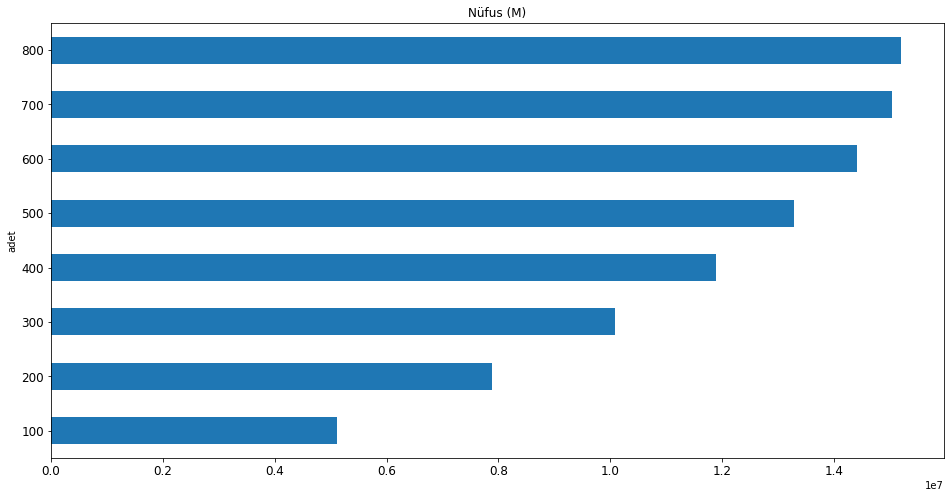

In [15]:
kapsayicilik.plot(kind='barh',
                  x='adet',
                  y='beklenen_nufus',
                  legend=None,
                  title='Nüfus (M)',
                  figsize=(16,8),
                  use_index=True,
                  yticks=[5.1, 7.8, 10.0, 11.8, 13.2, 14.4, 15.0, 15.2],
                  fontsize=12
                 )
plt.show()

### Pinpoints

In [16]:
ortalama_onem['ilce_sırası'] = ortalama_onem.groupby('ilce').cumcount() + 1
ortalama_onem = ortalama_onem.merge(toplanma[['id', 'lat', 'lon']], on='id')

### Görselleştirme

In [17]:
m = folium.Map(location=[41.0582, 28.9784], zoom_start=10)
count = 0
for index,row in ortalama_onem.iterrows():
    if(row.ilce_sırası == 1 or row.nufus_rn < 100):
        folium.Marker([row.lat, row.lon], icon=folium.Icon('red')).add_to(m)
        count += 1
    else:
        if index % 10 == 0:  # for visualization purpose
            folium.Marker([row.lat, row.lon], icon=folium.Icon('blue')).add_to(m)
m
#m.save('BelirlenenToplanmaAlanlari.html')